In [1]:
# 2023-10-04
# Goal: Identify the ecDNA+ CCLE lines
#       Identify gene dependencies in these lines
# @authors Owen Chapman and Rishaan Kenkre

In [151]:
import pandas as pd
import os
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
import seaborn as sns
import matplotlib.pyplot as plt

In [161]:

# CCLE files. Obtain from https://ampliconrepository.org/project/65008f133d950b28f536202b
ecDNA_data_file = os.path.join("results/aggregated_results.csv")
# DepMap files. Obtain from https://depmap.org/portal/download/all/
dep_data_file = os.path.join("CRISPRGeneDependency.csv")
dep_name_file = os.path.join("Model.csv")
ecDNA_tbl = pd.read_csv(ecDNA_data_file,index_col=0)
dep_tbl = pd.read_csv(dep_data_file)
name_tbl = pd.read_csv(dep_name_file,index_col="ModelID")
dep_tbl

,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.047757,0.047806,0.007155,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777
1,ACH-000004,0.023418,0.048724,0.058084,0.019483,0.049793,0.064472,0.001775,0.071289,0.003732,...,0.044517,0.471009,0.005096,0.015149,0.009804,0.015507,0.319598,0.007778,0.004392,0.048136
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.073457,0.281892,0.044789,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.160608,0.593581,0.017412,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.181632,0.342313,0.042414,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,ACH-002800,0.019522,0.048489,0.003258,0.008269,0.203445,0.010994,0.015949,0.047357,0.064302,...,0.006283,0.177775,0.024870,0.002609,0.028825,0.032515,0.155789,0.037765,0.034490,0.042029
1091,ACH-002834,0.035125,0.054841,0.015211,0.016620,0.154514,0.035249,0.011651,0.674236,0.013524,...,0.041955,0.716133,0.037090,0.042441,0.038526,0.020362,0.017330,0.224894,0.054621,0.562344
1092,ACH-002847,0.032003,0.045283,0.014737,0.010463,0.086174,0.017009,0.009417,0.405213,0.032471,...,0.261910,0.956598,0.008875,0.008511,0.015476,0.037763,0.145848,0.138299,0.053118,0.553382
1093,ACH-002922,0.024223,0.011662,0.012255,0.000397,0.135939,0.038571,0.004232,0.763590,0.007554,...,0.073170,0.899539,0.017797,0.001856,0.117058,0.034875,0.177452,0.056826,0.013545,0.295056


In [162]:
# get ecDNA+/- sets for CCLE.
def get_CCLE_ecDNA_y():
    return set(ecDNA_tbl[ecDNA_tbl.Classification == 'ecDNA']["Sample name"].drop_duplicates())
def get_CCLE_ecDNA_n():
    y = get_CCLE_ecDNA_y()
    return set(ecDNA_tbl["Sample name"])-y

In [163]:
def CCLE_Dep_Mapper(dep_tbl):
    # Get a mapping of CCLE names from 'name_tbl'
    name_map = name_tbl["CCLEName"].dropna()
    name_map = name_map[name_map.isin(get_CCLE_ecDNA_y() | get_CCLE_ecDNA_n())]

    # Get lists of ecDNA+ and ecDNA- samples
    ecDNA_positive = list(get_CCLE_ecDNA_y())
    ecDNA_negative = list(get_CCLE_ecDNA_n())

    # Create dictionaries to map CCLE samples to ecDNA status
    dict_positive = {p: "ecDNA+" for p in ecDNA_positive}
    dict_negative = {p: "ecDNA-" for p in ecDNA_negative}

    # Combine the dictionaries
    ecDNA_status = {**dict_positive, **dict_negative}

    # Convert 'name_map' to a dictionary
    name_map = name_map.to_dict()

    # Map DepMap ModelIDs to CCLE names
    dep_tbl["CCLE_Name"] = dep_tbl["ModelID"].map(name_map)
    dep_tbl["ecDNA Status"] = dep_tbl["CCLE_Name"].map(ecDNA_status) #maps depmap names to ecDNA status
    dep_tbl.dropna(subset = ['ecDNA Status'], inplace=True)
    # dep_tbl = dep_tbl.drop("CCLE_Name", axis = 1)
    phenotype_labels = dep_tbl[["ModelID", "ecDNA Status"]]

    return dep_tbl

dep_tbl = CCLE_Dep_Mapper(dep_tbl)
dep_tbl

,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),CCLE_Name,ecDNA Status
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.007155,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777,NIHOVCAR3_OVARY,ecDNA+
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.044789,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.017412,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325,LS513_LARGE_INTESTINE,ecDNA-
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.042414,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202,C2BBE1_LARGE_INTESTINE,ecDNA-
6,ACH-000012,0.054350,0.012480,0.007296,0.004775,0.017181,0.084226,0.002160,0.135486,0.019387,...,0.005066,0.010182,0.025559,0.011567,0.036698,0.064189,0.037076,0.144897,HCC827_LUNG,ecDNA+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,ACH-001129,0.006154,0.032343,0.021700,0.005665,0.091387,0.016325,0.013166,0.005379,0.011031,...,0.009847,0.044510,0.016679,0.007559,0.002623,0.006935,0.134144,0.304899,MONOMAC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-
695,ACH-001190,0.026710,0.019154,0.005128,0.026278,0.045072,0.132991,0.017355,0.230153,0.009186,...,0.014659,0.010182,0.013974,0.061360,0.185657,0.018651,0.034371,0.070354,SKMEL2_SKIN,ecDNA+
708,ACH-001239,0.035318,0.050906,0.014478,0.002191,0.051635,0.099943,0.004557,0.064424,0.012399,...,0.003860,0.007130,0.081788,0.005220,0.166237,0.010065,0.183644,0.292474,WM2664_SKIN,ecDNA-
723,ACH-001306,0.028519,0.019188,0.029996,0.012988,0.034118,0.035692,0.012886,0.115870,0.014186,...,0.041220,0.028705,0.081262,0.014079,0.075115,0.059332,0.433872,0.305545,8305C_THYROID,ecDNA+


In [164]:
# ecDNA+ is less than ecDNA-
#The CERES dependency score is based on data from a cell depletion assay. A lower CERES score indicates a higher likelihood that the gene of interest is essential in a given cell line. A score of 0 indicates a gene is not essential; correspondingly, −1 is comparable to the median of all pan-essential genes (red line). (https://www.frontiersin.org/articles/10.3389/fgene.2019.01245/full#:~:text=The%20CERES%20dependency%20score%20is,essential%20genes%20(red%20line).)
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import pandas as pd
from scipy import stats

def rr_stats_test(alternative):
    df = dep_tbl
    groups = df.groupby('ecDNA Status')
    ecDNA_positive_group = df[df['ecDNA Status'] == 'ecDNA+']
    ecDNA_negative_group = df[df['ecDNA Status'] == 'ecDNA-']

    test_results = {}
    
    for gene in df.columns[1:-1]:  # Assuming the first column is "ecDNA Status"
        ecDNA_positive = ecDNA_positive_group[gene]
        ecDNA_negative = ecDNA_negative_group[gene]

        stat, p_value = stats.ranksums(ecDNA_positive, ecDNA_negative, alternative=alternative)
        test_results[gene] = {'ranksums_statistic': stat, 'p_value': p_value}
    
    rr_results_df = pd.DataFrame.from_dict(test_results, orient='index')
    rr_results_df.to_csv('ranksums_test_results.tsv', sep='\t')
    
    return rr_results_df

rr_results_df = rr_stats_test("greater")

# len(rr_results_df)

In [165]:
def t_test():
    df = dep_tbl
    groups = df.groupby('ecDNA Status')
    ecDNA_positive_group = df[df['ecDNA Status'] == 'ecDNA+']
    ecDNA_negative_group = df[df['ecDNA Status'] == 'ecDNA-']
    # print(groups.head())
    # Create an empty DataFrame to store t-test results
    test_results = {}
    # print(df)
    for gene in df.columns[1:-1]:
        ecDNA_positive = ecDNA_positive_group[gene]
        ecDNA_negative = ecDNA_negative_group[gene]
        t_statistic, p_value = stats.ttest_ind(ecDNA_positive, ecDNA_negative)
        test_results[gene] = {'t_statistic': t_statistic, 'p_value': p_value}
    t_results_df = pd.DataFrame.from_dict(test_results, orient='index')
    t_results_df.to_csv('t_test_results.tsv', sep='\t')
    return t_results_df
t_results_df = t_test()
    



/Users/rkenkre/miniconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)

KeyboardInterrupt



In [6]:
def filtering_and_correction(df, statistic):
    filtered_results = df[~df['p_value'].isna()]
    filtered_genes = filtered_results.loc[filtered_results[statistic] > 0]
    # print(filtered_genes)
    filtered_genes['P_Value_Corrected'] = multipletests(filtered_genes['p_value'], method='fdr_bh')[1]
    print(filtered_genes.head(30))
    filtered_genes = filtered_genes.sort_values(by = "p_value", ascending = True)
    filtered_genes.reset_index()
    filtered_genes = filtered_genes.rename(columns={"index":"Gene"})
    filtered_genes = filtered_genes.sort_values(by = "P_Value_Corrected", ascending = False)
    filtered_genes = filtered_genes.loc[filtered_genes["P_Value_Corrected"] < 0.2]
    # filtered_genes.to_csv('less_filtered_genes.csv', index=True)
    return filtered_genes
 
greater_filtered_genes = filtering_and_correction(rr_results_df, 'ranksums_statistic')
# greater_filtered_genes = greater_filtered_genes.sort_values(by = "P_Value_Corrected", ascending = False)
greater_filtered_genes.to_csv('greater_filtered_genes.tsv', sep='\t')

len(greater_filtered_genes)

                  ranksums_statistic   p_value  P_Value_Corrected
A2M (2)                     0.711993  0.238234           0.452440
A3GALT2 (127550)            1.580991  0.056940           0.379430
A4GALT (53947)              1.597421  0.055086           0.378345
AAAS (8086)                 0.522129  0.300790           0.466567
AADAC (13)                  0.733901  0.231505           0.451132
AADACL2 (344752)            1.122759  0.130770           0.415193
AADAT (51166)               0.308530  0.378839           0.482348
AAGAB (79719)               1.816496  0.034647           0.347612
AAK1 (22848)                0.164306  0.434745           0.491899
AAR2 (25980)                0.220901  0.412585           0.486837
AARD (441376)               1.507966  0.065782           0.384496
AARS2 (57505)               1.451371  0.073338           0.387092
AASDH (132949)              0.228203  0.409744           0.486837
AASDHPPT (60496)            0.031036  0.487621           0.497040
AASS (1015

/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/3071802059.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_genes['P_Value_Corrected'] = multipletests(filtered_genes['p_value'], method='fdr_bh')[1]


16

In [156]:
changes = {}
df = dep_tbl
columns = df.columns.tolist()
# print(type(columns))
for col in columns: 
    gene = str(col).split(" ")
    changes[col] = gene[0]
df.rename(columns = changes, inplace = True)
df.head()

,ModelID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,CCLE_Name,ecDNA
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.007155,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777,NIHOVCAR3_OVARY,ecDNA+
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.044789,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.017412,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325,LS513_LARGE_INTESTINE,ecDNA-
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.042414,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202,C2BBE1_LARGE_INTESTINE,ecDNA-
6,ACH-000012,0.054350,0.012480,0.007296,0.004775,0.017181,0.084226,0.002160,0.135486,0.019387,...,0.005066,0.010182,0.025559,0.011567,0.036698,0.064189,0.037076,0.144897,HCC827_LUNG,ecDNA+


/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/3782634059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ecDNA Status'] = data['ecDNA'].map({'ecDNA+': True, 'ecDNA-': False})


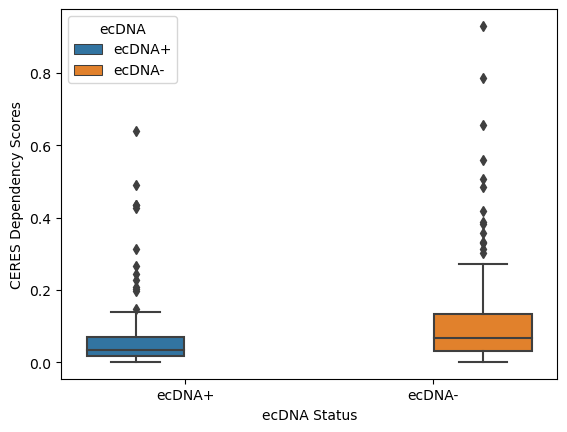

In [8]:
def box_plot(gene):
    data = df[[gene, "ecDNA"]]
    data['ecDNA Status'] = data['ecDNA'].map({'ecDNA+': True, 'ecDNA-': False})
    sns.boxplot(x = data['ecDNA'], 
                y = data[gene], 
                hue = data['ecDNA']).set(
        xlabel='ecDNA Status', 
        ylabel='Gene Dependency Scores'
    )
    plt.show()
box_plot("SMAD4")

/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/3782634059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ecDNA Status'] = data['ecDNA'].map({'ecDNA+': True, 'ecDNA-': False})


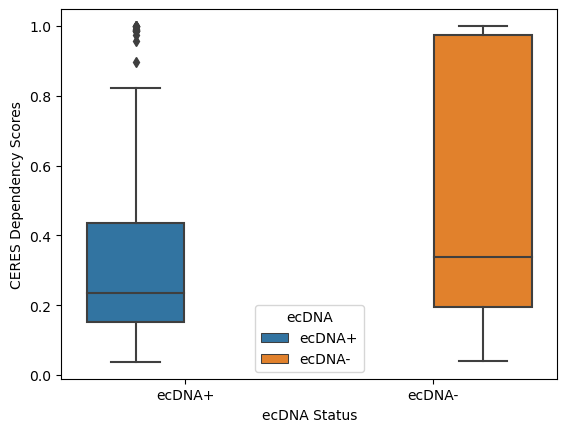

In [9]:
box_plot("MDM2")

/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/3782634059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ecDNA Status'] = data['ecDNA'].map({'ecDNA+': True, 'ecDNA-': False})


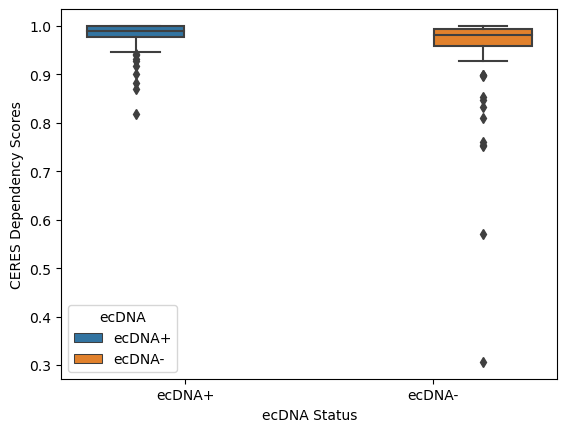

In [10]:
box_plot("INCENP")

In [12]:
df.to_csv("dep_tbl.csv")
df.head()

,ModelID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,CCLE_Name,ecDNA
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.007155,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777,NIHOVCAR3_OVARY,ecDNA+
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.044789,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.017412,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325,LS513_LARGE_INTESTINE,ecDNA-
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.042414,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202,C2BBE1_LARGE_INTESTINE,ecDNA-
6,ACH-000012,0.054350,0.012480,0.007296,0.004775,0.017181,0.084226,0.002160,0.135486,0.019387,...,0.005066,0.010182,0.025559,0.011567,0.036698,0.064189,0.037076,0.144897,HCC827_LUNG,ecDNA+


In [12]:
# Hits
"""
ANKRD11 - neural chromatin remodeler
ASNS - Asparagine synthetase
BRAF - proto-oncogene, MAPK/ERK signalling
CDK8 - cell cycle regulator
DCLRE1B - telomere protection, double-strand break induction.
EIF2AK4 - ribosome regulator, stress response. interacts with GCN1
FOXA1 - pioneer differentiation TF
GATA3 - hematopoetic differentiation TF
GCN1 - ribosome regulator, stress response. interacts with EIF2AK4
MDM2 - p53 regulation, recurrent ecDNA amplification
MDM4 - p53 regulation, recurrent ecDNA amplification
PGK1 - glycolysis
PPM1D - p53 regulation, recurrent ecDNA amplification
WRN - helicase, Holliday junction resolution
ZFR - rna-binding protein

TODO:
generate p-values, multiple hypothesis correction.
Remove genes amplified on ecDNA.
Confirm CRISPR score interpretation
Find drug dependency data
Test drugs
"""
dep_tbl.head()

,ModelID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,CCLE_Name,ecDNA
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.007155,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777,NIHOVCAR3_OVARY,ecDNA+
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.044789,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.017412,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325,LS513_LARGE_INTESTINE,ecDNA-
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.042414,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202,C2BBE1_LARGE_INTESTINE,ecDNA-
6,ACH-000012,0.054350,0.012480,0.007296,0.004775,0.017181,0.084226,0.002160,0.135486,0.019387,...,0.005066,0.010182,0.025559,0.011567,0.036698,0.064189,0.037076,0.144897,HCC827_LUNG,ecDNA+


In [173]:
import pandas as pd
greater_filtered_genes = pd.read_csv("greater_filtered_genes.tsv", sep = "\t")
greater_filtered_genes.rename(columns={"Unnamed: 0": "Gene"}, inplace = True)
sig_genes = greater_filtered_genes["Gene"].to_list()
for x in range(len(sig_genes)):
    element = str(sig_genes[x])
    gene = element.split(" ")[0]
    sig_genes[x] = gene
    
data = dep_tbl[dep_tbl.columns.intersection(sig_genes)]
# data
data["CCLE_Name"] = df["CCLE_Name"]
data["ecDNA"] = df["ecDNA"]
data["ModelID"] = df["ModelID"]
gene_dataframes = {}
score_columns = df.columns[1:-2]

# Filter columns where all values are less than 0.5
selected_columns = df[score_columns].columns[(df[score_columns] > 0.5).any()]

# Retain additional columns (like 'ModelID', 'CCLE_Name', 'ecDNA Status') in the resulting DataFrame
result_columns = ['ModelID', 'CCLE_Name', 'ecDNA'] + selected_columns.tolist()

# Create a new DataFrame with selected columns
result_df = df[result_columns]
    # print(gene_dataframes[column])# Store the DataFrame for the gene

# To access the DataFrame for a specific gene, e.g., 'Gene_1':
# column_value_counts = gene_dataframes['SKOR2']['CCLE_Name'].value_counts()
# max_value = column_value_counts.idxmax()
# max_count = column_value_counts.max()
# print(max_value)
# Print or use the resulting DataFrame 'result'
# gene_dataframes["DGKD"]
result_df.head()

/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/1772038924.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["CCLE_Name"] = df["CCLE_Name"]
/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/1772038924.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ecDNA"] = df["ecDNA"]
/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/1772038924.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,ModelID,CCLE_Name,ecDNA,A1CF,A3GALT2,A4GALT,AAAS,AAK1,AAMP,AAR2,...,ZSWIM7,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDA,ZYG11B,ZYX,ZZEF1,ZZZ3
0,ACH-000001,NIHOVCAR3_OVARY,ecDNA+,0.014039,0.049511,0.004955,0.131006,0.118776,0.987663,0.071789,...,0.053583,0.062080,0.455338,0.047757,0.047806,0.007155,0.015792,0.015999,0.006200,0.436777
2,ACH-000005,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-,0.025478,0.099322,0.099572,0.049601,0.025484,0.986824,0.048649,...,0.076117,0.088544,0.043417,0.073457,0.281892,0.044789,0.066269,0.025365,0.042530,0.096150
3,ACH-000007,LS513_LARGE_INTESTINE,ecDNA-,0.035082,0.022200,0.017121,0.149378,0.089304,0.990409,0.003270,...,0.019315,0.049765,0.099028,0.160608,0.593581,0.017412,0.369101,0.015412,0.165622,0.366325
4,ACH-000009,C2BBE1_LARGE_INTESTINE,ecDNA-,0.074860,0.021632,0.067758,0.216796,0.117095,0.984175,0.054858,...,0.061845,0.217184,0.039634,0.181632,0.342313,0.042414,0.651365,0.012016,0.023990,0.312202
6,ACH-000012,HCC827_LUNG,ecDNA+,0.012480,0.017181,0.084226,0.135486,0.062442,0.980586,0.078416,...,0.098399,0.129368,0.063034,0.613941,0.941892,0.005066,0.036698,0.064189,0.037076,0.144897


In [185]:
df['New_CCLE_Name'] = df['CCLE_Name'].str.split('_', n=1).str.get(1)
df.head()

,ModelID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,CCLE_Name,ecDNA,New_CCLE_Name
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777,NIHOVCAR3_OVARY,ecDNA+,OVARY
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-,HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325,LS513_LARGE_INTESTINE,ecDNA-,LARGE_INTESTINE
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202,C2BBE1_LARGE_INTESTINE,ecDNA-,LARGE_INTESTINE
6,ACH-000012,0.054350,0.012480,0.007296,0.004775,0.017181,0.084226,0.002160,0.135486,0.019387,...,0.010182,0.025559,0.011567,0.036698,0.064189,0.037076,0.144897,HCC827_LUNG,ecDNA+,LUNG


/var/folders/vv/261hv1sn1h36hvx1wc1cv9w40000gp/T/ipykernel_76322/2688902567.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_df['New_CCLE_Name'] = gene_df['CCLE_Name'].str.split('_', n=1).str.get(1)


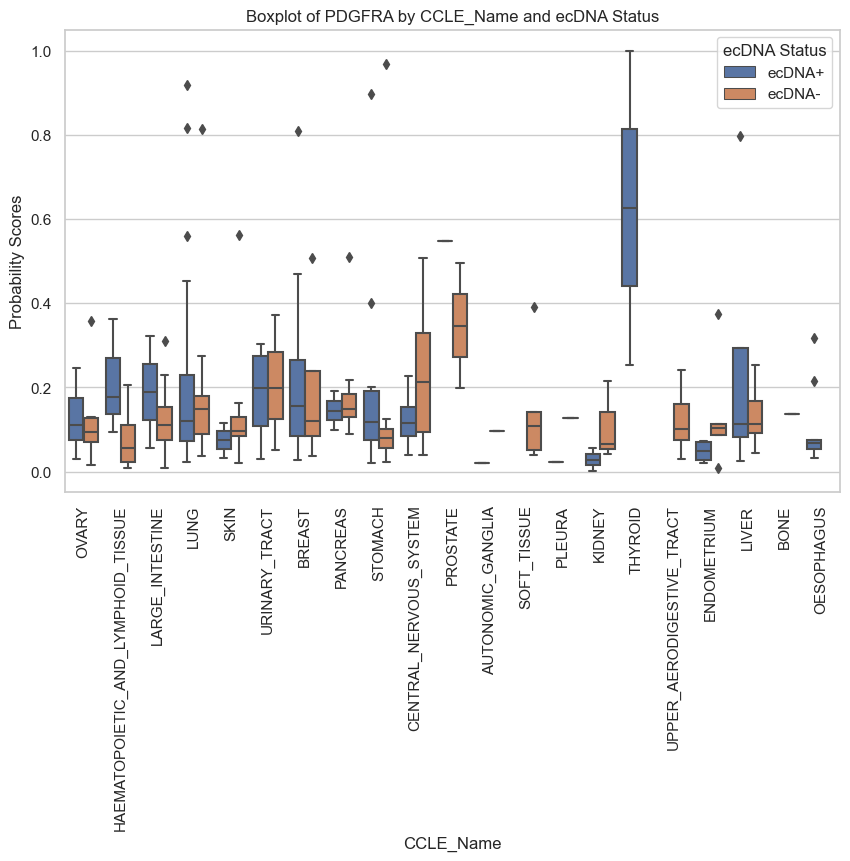

In [520]:
def create_boxplot(gene):
    # Filter genes_dataframes for the specified gene
    gene_df = result_df[[gene, 'CCLE_Name', 'ecDNA']]
    # print(gene_df)
    # Create a boxplot
    gene_df['New_CCLE_Name'] = gene_df['CCLE_Name'].str.split('_', n=1).str.get(1)
    #filtered_genes = filtered_results.loc[filtered_results[statistic] > 0]
    # gene_df = gene_df.loc[gene_df[gene] > 0.99]
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    boxplot = sns.boxplot(x="New_CCLE_Name", y=gene, hue="ecDNA", data=gene_df)
    boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)
    plt.title(f'Boxplot of {gene} by CCLE_Name and ecDNA Status')
    plt.xlabel('CCLE_Name')
    plt.ylabel('Probability Scores')
    plt.legend(title='ecDNA Status')
    # plt.yticks([0.99, 1.0])
    plt.show()
create_boxplot("PDGFRA")

In [344]:
import pandas as pd
from scipy.stats import ranksums
# df.loc[df['column_name'] == some_value]
def run_rr(gene, cancer_type):
    gene_df = df[[gene, 'New_CCLE_Name', 'ecDNA']]
    gene_df = gene_df.loc[gene_df["New_CCLE_Name"] == cancer_type]
    ecDNA_positive = gene_df.loc[gene_df["ecDNA"] == "ecDNA+"][gene]
    ecDNA_negative = gene_df.loc[gene_df["ecDNA"] == "ecDNA-"][gene]
    stat, p_value = stats.ranksums(ecDNA_positive, ecDNA_negative, alternative = "greater")
    print('ranksums_statistic: ', stat)
    print('p_value: ', p_value)
run_rr("MSTO1", "LUNG")
    

ranksums_statistic:  -0.3893314107138301
p_value:  0.6514844983550516


In [187]:
df.head()

,ModelID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,CCLE_Name,ecDNA,New_CCLE_Name
0,ACH-000001,0.055321,0.014039,0.014084,0.033828,0.049511,0.004955,0.026993,0.131006,0.003102,...,0.002537,0.003660,0.154849,0.015792,0.015999,0.006200,0.436777,NIHOVCAR3_OVARY,ecDNA+,OVARY
2,ACH-000005,0.059552,0.025478,0.009989,0.008775,0.099322,0.099572,0.007544,0.049601,0.047555,...,0.058229,0.029638,0.097357,0.066269,0.025365,0.042530,0.096150,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ecDNA-,HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
3,ACH-000007,0.023880,0.035082,0.006556,0.004322,0.022200,0.017121,0.009605,0.149378,0.052873,...,0.001892,0.006432,0.029261,0.369101,0.015412,0.165622,0.366325,LS513_LARGE_INTESTINE,ecDNA-,LARGE_INTESTINE
4,ACH-000009,0.027652,0.074860,0.011021,0.009153,0.021632,0.067758,0.013559,0.216796,0.013660,...,0.002859,0.058070,0.053355,0.651365,0.012016,0.023990,0.312202,C2BBE1_LARGE_INTESTINE,ecDNA-,LARGE_INTESTINE
6,ACH-000012,0.054350,0.012480,0.007296,0.004775,0.017181,0.084226,0.002160,0.135486,0.019387,...,0.010182,0.025559,0.011567,0.036698,0.064189,0.037076,0.144897,HCC827_LUNG,ecDNA+,LUNG


In [ ]:
#run targeted wilcoxon test